# Modelling Galaxy Masses Using a Neural Network

In [19]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In cosmology, calculating masses of galaxies is an important part of understanding galactic structure and dynamics. Discrepancies between the total baryonic mass of a galaxy and its mass as inferred from its dynamics was crucial in the discovery of dark matter, and being able to deduce the total mass of a galaxy from its light and colours remains an important exercise in improving scientific understanding of galaxies and cosmology. [Francis et al. (2025)](https://ui.adsabs.harvard.edu/link_gateway/2025AJ....169..186D/doi:10.3847/1538-3881/adaf21) present a model to convert Wide-field Infrared Spectroscopy Explorer (WISE) W1-band fluxes into stellar masses. As part of their work, they include a table of total stellar masses of a number of galaxies, alongside their total luminosity in the W1 band and g-W1 photometric colours. In this report, I train and test a neural network on this dataset. Specifically, this model retrieves the total mass of a galaxy based on inputs of galaxy luminosity and g-W1 colour.

The raw data from the study, retrieved from [SPARC](https://astroweb.case.edu/SPARC/) (associated with [Lelli, McGaugh and Schombert, 2016](https://ui.adsabs.harvard.edu/link_gateway/2016AJ....152..157L/doi:10.3847/0004-6256/152/6/157)), can be found in `wise_ii.table1.txt`. We start by extracting and viewing the data:

In [18]:
# load data
data = "wise_ii.table1.txt"
with open(data) as f:
    lines = f.readlines()

# process data
data = []
for line in lines[16:]: # remove header
    values = line.split()
    data.append([v for v in values])

data = pd.DataFrame(data, columns=['Galaxy', 'LogL', 'LogM', 'err_M', 'g-W1', 'M/L'])
data = data.astype({'Galaxy': 'str','LogL': 'float', 'LogM': 'float', 'err_M': 'float', 'g-W1': 'float', 'M/L': 'float'})
data = data.sample(frac=1).reset_index(drop=True) # shuffle data in case of bias in ordering
data

,Galaxy,LogL,LogM,err_M,g-W1,M/L
0,NGC2403,10.014,9.760,0.018,2.97,0.56
1,NGC4051,11.145,11.057,0.006,3.46,0.82
2,F568-V1,9.439,9.174,0.036,2.85,0.54
3,NGC3726,10.837,10.706,0.006,3.31,0.74
4,UGC03546,10.965,10.744,0.006,3.08,0.60
...,...,...,...,...,...,...
106,F568-1,9.674,9.411,0.061,2.50,0.55
107,UGC07151,9.352,9.117,0.016,3.04,0.58
108,UGC07232,7.968,7.704,0.032,2.54,0.55
109,NGC5585,9.487,9.222,0.008,2.78,0.54


Note that due to large numbers, we are dealing with logarithmic masses and luminosities. Both of these values are scaled according to solar quantities. g-W1 colours are in units of magnitude.

## Model Description

The model takes in two input variables:
1. $x_1=\log_{10}(\mathrm{Luminosity}/\mathrm{L}_\odot)$
2. $x_2=g-\mathrm{W1}$

And produces one output:
1. $y_1=\log_{10}(\mathrm{Mass}/\mathrm{M}_\odot)$

We can visualise the training data using 3D plots. Note that the inputs have been normalised between 0 and 1 as is best practice.

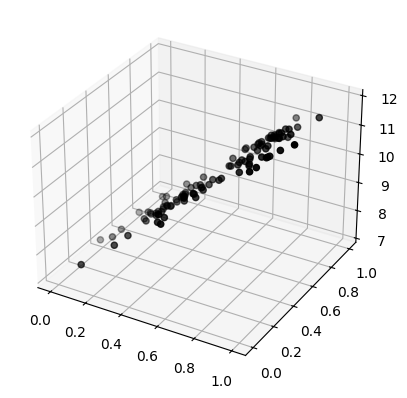

In [37]:
# set x and y
x = np.column_stack([data['LogL'], data['g-W1']])
x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0)) # normalise
y = np.array(data['LogM']).reshape(-1,1)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], y[:,0], c='k', marker='o')

In [35]:
len(y[:,0])

111

We now split data into training, validation, and test sets using the 70/20/10 rule.

In [ ]:
# split into training, validation, test sets
train_size = int(0.7 * len(x))
valid_size = int(0.2 * len(x))
test_size = len(x) - train_size - valid_size

x_train, x_valid, x_test = x[:train_size], x[train_size:train_size+valid_size], x[-test_size:]
y_train, y_valid, y_test = y[:train_size], y[train_size:train_size+valid_size], y[-test_size:]

print("Training Data: {} {}".format(x_train.shape, y_train.shape))
print("Validation Data: {} {}".format(x_valid.shape, y_valid.shape))
print("Test Data: {} {}".format(x_test.shape, y_test.shape))

## Network Architecture

In [ ]:
# activation functions
def relu(x):
    return np.maximum(0, x)

# linear output for regression
def linear(x):
    return x

# derivatives
def relu_derivative(x):
    results = np.ones_like(x)
    results[x < 0] = 0
    return results

In [5]:
# network sizes
input_layer = 2
hidden_layer = 8
output_layer = 1

# initialize weights and biases (use a small scale to ensure stable updates with lr=0.1)
init_scale = 0.001
rng = np.random.default_rng(42)
w1 = init_scale * rng.normal(0, np.sqrt(2/input_layer), size=(hidden_layer, input_layer))
b1 = np.zeros((hidden_layer, 1))
w2 = init_scale * rng.normal(0, np.sqrt(2/hidden_layer), size=(output_layer, hidden_layer))
b2 = np.zeros((output_layer, 1))

# defining how the neuron works
def f_z(x,w,b):
    return (np.matmul(w, x.T)+b).T

def f_y1(x, w1, b1):
    z1 = f_z(x, w1, b1)
    return relu(z1)

def f_y2(y1, w2, b2):
    z2 = f_z(y1, w2, b2)
    return linear(z2)

def feed_forward(x,w1,b1,w2,b2):
    y1 = f_y1(x, w1, b1)
    y2 = f_y2(y1, w2, b2)
    return y2

In [6]:
def loss_rmse(y_true, y_pred):
    y_t = np.asarray(y_true).reshape(-1,1)
    y_p = np.asarray(y_pred).reshape(-1,1)
    return np.sqrt(np.mean((y_t - y_p)**2))

In [7]:
def gradient_descent(x,y,w1,b1,w2,b2):
    # x: (N, input_layer)
    # y: (N,1)
    N = x.shape[0]

    # forward
    z1 = f_z(x, w1, b1)      # (N, hidden_layer)
    y1 = f_y1(x, w1, b1)     # (N, hidden_layer)
    y2 = f_y2(y1, w2, b2)    # (N, output_layer)

    # loss derivative for MSE, dL/dy_pred = 2*(y_pred - y_true)/N
    dLdy2 = 2*(y2 - y) / N   # (N,1)

    # gradients for w2 and b2
    # w2 shape (output_layer, hidden_layer)
    dLdw2 = np.matmul(dLdy2.T, y1)  # (1, hidden_layer)
    dLdb2 = np.sum(dLdy2, axis=0).reshape(-1,1)  # (1,1)

    # backprop into hidden layer
    dy1dz1 = relu_derivative(z1)  # (N, hidden_layer)
    dLdz1 = np.matmul(dLdy2, w2) * dy1dz1  # (N, hidden_layer)

    # gradients for w1 and b1
    # w1 shape (hidden_layer, input_layer)
    dLdw1 = np.matmul(dLdz1.T, x)  # (hidden_layer, input_layer)
    dLdb1 = np.sum(dLdz1, axis=0).reshape(-1,1)  # (hidden_layer,1)

    return {'dLdw1': dLdw1, 'dLdw2': dLdw2, 'dLdb1': dLdb1, 'dLdb2': dLdb2}

In [10]:
# training loop with accept/reject (keeps l_rate constant)
# l_rate remains equal to the user-provided value throughout
l_rate = 0.5  # set this before running; will not be changed by the loop
Nepoch = 10
loss_train = np.zeros(Nepoch)
loss_valid = np.zeros(Nepoch)

for step in range(Nepoch):
    # evaluate current losses
    output_train = feed_forward(x_train, w1, b1, w2, b2)
    loss_train[step] = loss_rmse(y_train, output_train)
    output_valid = feed_forward(x_valid, w1, b1, w2, b2)
    loss_valid[step] = loss_rmse(y_valid, output_valid)

    # compute gradients on training set
    grads = gradient_descent(x_train, y_train, w1, b1, w2, b2)

    # If learning rate is greater than 0.1, allow regular update (may increase loss)
    if l_rate > 0.1:
        w1 = w1 - l_rate * grads['dLdw1']
        b1 = b1 - l_rate * grads['dLdb1']
        w2 = w2 - l_rate * grads['dLdw2']
        b2 = b2 - l_rate * grads['dLdb2']
    else:
        # For l_rate <= 0.1, compute tentative update using the same l_rate and accept only
        # if it does not increase the training loss. This preserves the input learning rate.
        w1_new = w1 - l_rate * grads['dLdw1']
        b1_new = b1 - l_rate * grads['dLdb1']
        w2_new = w2 - l_rate * grads['dLdw2']
        b2_new = b2 - l_rate * grads['dLdb2']

        out_train_new = feed_forward(x_train, w1_new, b1_new, w2_new, b2_new)
        new_loss = loss_rmse(y_train, out_train_new)

        if new_loss <= loss_train[step]:
            # accept update (l_rate unchanged)
            w1, b1, w2, b2 = w1_new, b1_new, w2_new, b2_new
        else:
            # reject update (no parameter change) to keep loss non-increasing
            pass

# After training you can plot loss_train/loss_valid in the next cell
print('Final training loss:', loss_train[-1])

Final training loss: 1.1116255464139704


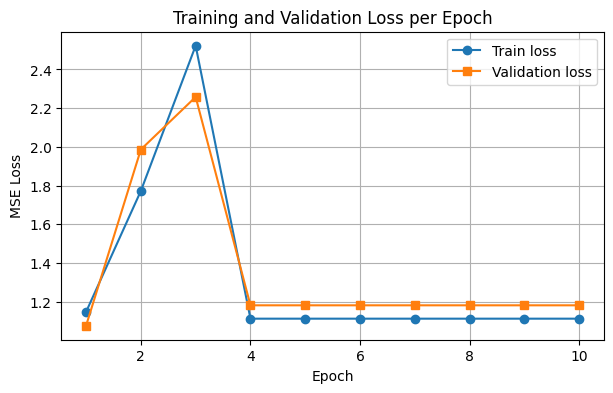

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation loss vs epoch
epochs = np.arange(1, Nepoch+1)
plt.figure(figsize=(7,4))
plt.plot(epochs, loss_train, marker='o', label='Train loss')
plt.plot(epochs, loss_valid, marker='s', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
# save a copy to the assignment folder
#plt.savefig('assignment-4/loss_vs_epoch.png', bbox_inches='tight')
plt.show()
#print("Saved plot to assignment-4/loss_vs_epoch.png")

## Gradient Equations

## Comparing Learning Rates